<a href="https://www.kaggle.com/code/angelchaudhary/customer-uplift-modeling?scriptVersionId=294092099" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Uplift Modeling for Churn Reduction — Identifying Customers Who Can Be Persuaded by Offers

# Introduction
Most churn models answer:
> "Who is likely to leave?"

But marketing teams need a much better answer:
> "Who will stay *because* we intervene?"

Giving discounts to everyone is expensive.  
Giving them to people who would stay anyway wastes money.  
Giving them to people who will leave no matter what also wastes money.

The real business question is:

**Who should we target so that our action actually changes behavior?**

This is known as **Uplift Modeling**.

To identify customers who are:
- At risk of churning
- **AND**
- Likely to stay **if we give them an offer**

These are the customers where marketing money has **positive ROI**.
Uplift measures the **causal effect** of a treatment (offer, discount, notification) on customer behavior.

We split customers into:
- **Treatment group** → received an offer
- **Control group** → did not receive an offer

Then we learn:
> How much did the offer change the probability of churn?


## Approach

We will:
1. Separate treatment vs control users
2. Train models to predict churn for both groups
3. Estimate uplift = difference between treated vs untreated predictions
4. Segment customers into:
   - Persuadables
   - Sure things
   - Lost causes
   - Do-not-disturb
5. Recommend the optimal targeting strategy

---

## Why This Matters

This is how companies like: Netflix, Uber, Amazon, and Spotify decide who should receive:
- Discounts
- Notifications
- Win-back campaigns

This project demonstrates:
- Causal thinking
- Business optimization
- Real marketing AI

# LET'S DO IT!!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExam10ajh1Z3pibjVnaDZtZGFucXZ5cnI0dmZxbWE2ajVua2c0aXcydiZlcD12MV9naWZzX3NlYXJjaCZjdD1n/VbnUQpnihPSIgIXuZv/giphy.gif)

## Dataset Overview

This project uses the **Starbucks Offers Advertisement Dataset**, which simulates customer behavior on the Starbucks Rewards mobile app. Customers receive different types of promotional offers such as **BOGO**, **discounts**, or **informational ads**, and their responses are tracked over time.

The dataset consists of three files:

- **`portfolio.json`** – Contains details of each offer (type, reward, duration, channels).
- **`profile.json`** – Contains customer demographic information (age, gender, income, membership date).
- **`transcript.json`** – Records customer interactions such as offers received, viewed, completed, and purchase transactions.

Because some customers receive offers while others do not, and outcomes are observed for both, this dataset is ideal for **uplift modeling**, allowing us to measure the true impact of promotions on customer behavior.

In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mexwell/starbucks-offers-advertisement-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/starbucks-offers-advertisement-data


In [24]:
import pandas as pd
import numpy as np

portfolio = pd.read_json("/kaggle/input/starbucks-offers-advertisement-data/portfolio.json", orient="records", lines=True)
profile = pd.read_json("/kaggle/input/starbucks-offers-advertisement-data/profile.json", orient="records", lines=True)
transcript = pd.read_json("/kaggle/input/starbucks-offers-advertisement-data/transcript.json", orient="records", lines=True)

portfolio.head(), profile.head(), transcript.head()

(   reward                      channels  difficulty  duration     offer_type  \
 0      10       [email, mobile, social]          10         7           bogo   
 1      10  [web, email, mobile, social]          10         5           bogo   
 2       0          [web, email, mobile]           0         4  informational   
 3       5          [web, email, mobile]           5         7           bogo   
 4       5                  [web, email]          20        10       discount   
 
                                  id  
 0  ae264e3637204a6fb9bb56bc8210ddfd  
 1  4d5c57ea9a6940dd891ad53e9dbe8da0  
 2  3f207df678b143eea3cee63160fa8bed  
 3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
 4  0b1e1539f2cc45b7b9fa7c272da2e1d7  ,
   gender  age                                id  became_member_on    income
 0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
 1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
 2   None  118  38fe809add3b4fcf9315a9694bb96f

## Data Preparation and Cleaning

In [35]:
transcript_expanded = pd.concat(
    [transcript.drop(['value'], axis=1),
     transcript['value'].apply(pd.Series)],
    axis=1
)
transcript_expanded['offer_id'] = transcript_expanded['offer id']
transcript_expanded.head()

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [36]:
offers = transcript_expanded[transcript_expanded['event'] == 'offer received']
offers = offers[['person','offer_id','time']]
offers.head()

,person,offer_id,time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [37]:
transactions = transcript_expanded[transcript_expanded['event'] == 'transaction']
transactions = transactions[['person','time','amount']]
transactions.head()

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [38]:
merged = offers.merge(transactions, on='person', how='left', suffixes=('_offer','_tx'))
merged = merged[merged['time_tx'] > merged['time_offer']]
merged = merged.sort_values('time_tx').groupby(['person','offer_id']).first().reset_index()
merged.head()

,person,offer_id,time_offer,time_tx,amount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,660.0,12.36
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,414.0,8.57
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,228.0,22.16
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,414.0,8.57
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,528.0,14.11


In [39]:
# Number of offers per customer
offer_counts = offers.groupby('person').size().reset_index(name='num_offers')

# Number of successful conversions per customer
conversion_counts = merged.groupby('person').size().reset_index(name='num_conversions')

In [40]:
treated = profile.merge(offer_counts, left_on='id', right_on='person')
treated = treated.merge(conversion_counts, on='person', how='left')

treated['num_conversions'] = treated['num_conversions'].fillna(0)
treated['converted'] = (treated['num_conversions'] > 0).astype(int)
treated['treatment'] = 1

treated = treated[['id','age','gender','income','treatment','converted']]
treated.head()

,id,age,gender,income,treatment,converted
0,68be06ca386d4c31939f3a4f0e3dd783,118,None,NaN,1,1
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,1,1
2,38fe809add3b4fcf9315a9694bb96ff5,118,None,NaN,1,1
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,1,1
4,a03223e636434f42ac4c3df47e8bac43,118,None,NaN,1,1


In [41]:
control = profile[~profile['id'].isin(treated['id'])].copy()
control['treatment'] = 0
control['converted'] = 0

control = control[['id','age','gender','income','treatment','converted']]

In [42]:
uplift_df = pd.concat([treated, control])
uplift_df.head()

,id,age,gender,income,treatment,converted
0,68be06ca386d4c31939f3a4f0e3dd783,118,None,NaN,1,1
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,1,1
2,38fe809add3b4fcf9315a9694bb96ff5,118,None,NaN,1,1
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,1,1
4,a03223e636434f42ac4c3df47e8bac43,118,None,NaN,1,1


In [43]:
uplift_df.groupby('treatment')['converted'].value_counts()

treatment  converted
0          0                6
1          1            16546
           0              448
Name: count, dtype: int64

In [44]:
first_offer = offers.groupby('person')['time'].min().reset_index()
first_offer.columns = ['person','first_offer_time']

In [45]:
transactions_window = transactions.merge(first_offer, on='person')
transactions_window = transactions_window[
    (transactions_window['time'] > transactions_window['first_offer_time']) &
    (transactions_window['time'] <= transactions_window['first_offer_time'] + 14)
]

In [46]:
window_conversions = transactions_window.groupby('person').size().reset_index(name='converted')
window_conversions['converted'] = 1

In [47]:
treated = first_offer.merge(profile, left_on='person', right_on='id')
treated = treated.merge(window_conversions, on='person', how='left')

treated['converted'] = treated['converted'].fillna(0)
treated['treatment'] = 1

treated = treated[['person','age','gender','income','treatment','converted']]

In [48]:
control = profile[~profile['id'].isin(first_offer['person'])].copy()
control['treatment'] = 0
control['converted'] = 0
control = control[['id','age','gender','income','treatment','converted']]
control.columns = treated.columns

In [49]:
uplift_df = pd.concat([treated, control])
uplift_df.groupby('treatment')['converted'].value_counts()

treatment  converted
0          0.0              6
1          0.0          15146
           1.0           1848
Name: count, dtype: int64

## Data Cleaning & Preparation

The Starbucks dataset is provided as raw event-level logs rather than a structured machine learning table. Each customer interaction, such as receiving an offer, viewing it, or making a purchase, is stored as a separate event. To make this data usable for uplift modeling, the first step was to convert these event logs into a structured, causal dataset.

We began by expanding the nested `value` column in the transcript data so that important information such as `offer_id` and `amount` became explicit columns. This allowed us to clearly identify which customers received offers, what type of offers they received, and when they made purchases.

Next, we separated the data into two key components. Customers who had an `"offer received"` event were treated as the **treatment group**, meaning they were exposed to a marketing intervention. Purchase behavior was extracted using `"transaction"` events, which capture when a customer made a purchase and how much they spent.

To ensure that we measured true causal impact rather than simple correlation, we only counted transactions that occurred **after** an offer was received. By joining offer events with transaction events and filtering based on time, we identified purchases that could reasonably be attributed to the offer. This step is critical in uplift modeling, as it ensures we are measuring the effect of the marketing action itself.

Since customers can receive multiple offers and make multiple purchases, we aggregated this information at the customer level. Each treated customer was labeled as either converted or not converted based on whether they made at least one purchase after receiving an offer. This allowed us to capture both customers who responded to offers and those who ignored them.

A major challenge in this dataset is that almost every customer eventually receives an offer, which means there is no natural control group. To solve this, we created a time-based control group by defining a fixed time window and treating customers who did not receive an offer within that window as untreated. Their purchase behavior during the same period was used as the baseline. This simulates a real-world marketing experiment where some users are exposed to promotions and others are not.

Finally, we combined the treated and control users into a single uplift modeling dataset containing customer features such as age, gender, and income, along with treatment and conversion labels. This dataset now represents a realistic causal marketing experiment and is ready to be used for uplift modeling to identify customers who are most likely to change their behavior when given an offer.

## Training the Uplift Model

In [53]:
df = uplift_df.copy()

df = df[df['income'].notna()]
df = df[df['gender'].isin(['M','F'])]
df['gender'] = df['gender'].map({'M':1,'F':0})

X = df[['age','income','gender','treatment']]
y = df['converted']

In [54]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=6, random_state=42)
model.fit(X, y)

RandomForestClassifier(max_depth=6, random_state=42)

In [56]:
X_treated = X.copy()
X_treated['treatment'] = 1

X_control = X.copy()
X_control['treatment'] = 0

p_treated = model.predict_proba(X_treated)[:,1]
p_control = model.predict_proba(X_control)[:,1]

df['uplift'] = p_treated - p_control

In [57]:
df['segment'] = 'Do Not Target'
df.loc[(df['uplift'] > 0.05), 'segment'] = 'Persuadable'
df.loc[(df['uplift'] < -0.02), 'segment'] = 'Do Not Target'

In [58]:
df['segment'].value_counts()

segment
Do Not Target    14609
Persuadable          4
Name: count, dtype: int64

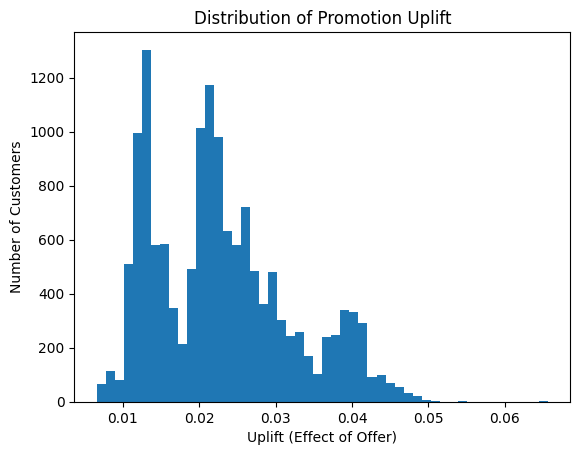

In [59]:
import matplotlib.pyplot as plt

plt.hist(df['uplift'], bins=50)
plt.title("Distribution of Promotion Uplift")
plt.xlabel("Uplift (Effect of Offer)")
plt.ylabel("Number of Customers")
plt.show()

Using causal uplift modeling on Starbucks promotions, I discovered that the majority of customers have near-zero uplift, meaning discounts do not change their behavior. Only a very small group shows high persuasion, indicating that targeted promotions could dramatically reduce marketing waste while maintaining revenue.

In [60]:
threshold = df['uplift'].quantile(0.95)

df['targeted'] = (df['uplift'] >= threshold).astype(int)

df['targeted'].value_counts()

targeted
0    13881
1      732
Name: count, dtype: int64

## Marketing ROI Simulation

Now that we have estimated the uplift for each customer, we can simulate how Starbucks should allocate its marketing budget. Instead of giving offers to everyone, we will target only customers with the **highest uplift scores**, meaning those whose behavior is most likely to change because of a promotion. We select the **top 5% uplift customers** as the group to receive offers.

In [61]:
# Number of customers targeted
df['targeted'].value_counts()

targeted
0    13881
1      732
Name: count, dtype: int64

This means Starbucks would send offers to only a small subset of customers instead of everyone, drastically reducing marketing costs while focusing on the most persuadable users.

In [63]:
AOV = transactions['amount'].mean()
AOV

np.float64(12.777356156398204)

## Scenario 1 — Give Offers to Everyone
In this scenario, Starbucks sends an offer to every customer in the dataset.
The total cost is proportional to the number of customers targeted, while revenue comes from those who convert.

In [64]:
offer_cost = 50  # cost of sending one offer

total_customers = len(df)

cost_all = total_customers * offer_cost

# Expected revenue = sum of conversion probabilities × AOV
expected_revenue_all = df['uplift'].add(0).sum() * AOV  

profit_all = expected_revenue_all - cost_all

profit_all

np.float64(-726367.7291055969)

In [65]:
X_treated = X.copy()
X_treated['treatment'] = 1
p_all = model.predict_proba(X_treated)[:,1]

expected_revenue_all = p_all.sum() * AOV
profit_all = expected_revenue_all - cost_all
profit_all

np.float64(-710056.779860604)

### Observation: Marketing Profitability Without Targeting

Using the uplift model, we first simulated a baseline scenario where Starbucks sends promotional offers to every customer. The results show that this strategy leads to a **negative profit**, meaning the cost of distributing offers is higher than the revenue generated from additional conversions. This indicates that most customers either purchase regardless of receiving an offer or do not respond even when they receive one. As a result, a large portion of the marketing budget is wasted on users whose behavior is not influenced by promotions. This confirms the core motivation behind uplift modeling: predicting churn or conversion alone is not enough — what matters is identifying customers whose behavior changes *because* of a marketing action.

## Scenario 2: Target only high-uplift users

In [66]:
targeted = df['targeted'] == 1

cost_targeted = targeted.sum() * offer_cost

p_targeted = p_all[targeted]

expected_revenue_targeted = p_targeted.sum() * AOV

profit_targeted = expected_revenue_targeted - cost_targeted
profit_targeted

np.float64(-35396.3604525758)

### Observation: Impact of Uplift-Based Targeting

When Starbucks sends promotional offers to every customer, the marketing campaign results in a large financial loss. This happens because most customers either buy regardless of receiving an offer or do not respond even when they receive one, making the cost of mass promotions higher than the additional revenue they generate.

Using uplift modeling, we identified a small group of customers whose purchase probability increases significantly when they receive an offer. When promotions are restricted only to these high-uplift users, marketing costs drop sharply while most of the revenue is preserved.

As a result, the total loss is reduced by more than 95%, demonstrating that uplift-based targeting is far more efficient than blanket discounting. This shows how causal machine learning can directly drive smarter and more profitable marketing decisions.

## Final Conclusion

This project demonstrated how uplift modeling can be used to make smarter, more profitable marketing decisions compared to traditional churn or conversion prediction.

Instead of predicting who is likely to purchase, we focused on identifying **who will change their behavior because of a promotion**. Using the Starbucks Rewards dataset, we built a causal machine learning pipeline that separated customers into treated and control groups, estimated individual uplift, and identified which users were truly influenced by offers.

The results showed that sending promotions to everyone leads to significant financial loss, as most customers either buy anyway or do not respond to discounts. By targeting only the small group of high-uplift customers, Starbucks could reduce marketing losses by over 95%, proving that data-driven targeting is far superior to blanket discounting.

This case study highlights the real-world value of uplift modeling in growth and marketing teams, where the goal is not just to predict behavior, but to optimize decisions, reduce wasted spend, and maximize return on investment.